[Warning] 1 rotation matrices contain NaN. Replacing with I.
torch.Size([150, 4, 4]) torch.Size([1, 150, 4, 4])
torch.Size([1, 150, 6]) torch.Size([1, 1, 6]) torch.Size([1, 150, 4, 4]) torch.Size([1, 1, 4, 4])


/tmp/ipykernel_3354309/4160066332.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


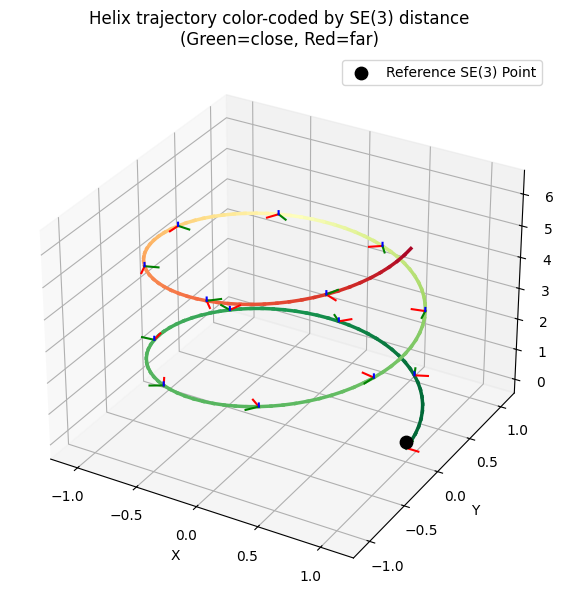

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils.distance import riemann_anisotropic_distance_SE3_PT
from utils.SE3_functions import *
from utils.Lie_old import *
# ---------------------------------------
# 1. Basic SE(3) utilities
# ---------------------------------------
def hat(v):
    w = torch.zeros(v.shape[:-1] + (3,3), device=v.device, dtype=v.dtype)
    w[...,0,1] = -v[...,2]; w[...,0,2] = v[...,1]
    w[...,1,0] = v[...,2];  w[...,1,2] = -v[...,0]
    w[...,2,0] = -v[...,1]; w[...,2,1] = v[...,0]
    return w


def make_SE3(R, p):
    B, Tn = R.shape[:2]
    T = torch.eye(4, device=R.device, dtype=R.dtype).repeat(B,Tn,1,1)
    T[...,:3,:3] = R
    T[...,:3,3] = p
    return T

def invSE3(T):
    R = T[...,:3,:3]
    p = T[...,:3,3]
    Tinv = torch.eye(4, device=T.device, dtype=T.dtype).expand_as(T).clone()
    Tinv[...,:3,:3] = R.transpose(-1,-2)
    Tinv[...,:3,3] = -torch.matmul(R.transpose(-1,-2), p.unsqueeze(-1))[...,0]
    return Tinv

# ---------------------------------------
# 2. Helix trajectory
# ---------------------------------------
B, Tn = 1, 150
t = torch.linspace(0, 4*np.pi, Tn)
device = torch.device('cpu')

r = 1.0
c = 0.5

p = torch.stack([
    r * torch.cos(t),
    r * torch.sin(t),
    c * t
], dim=-1).unsqueeze(0).to(device)

axis = torch.tensor([0., 0., 1.], device=device).expand(Tn, 3)
w = axis * (0.5 * t).unsqueeze(-1)
R = expSO3(w).unsqueeze(0)
nan_mask = torch.isnan(R).any(dim=(-2, -1))  # (...,)
if nan_mask.any():
    print(f"[Warning] {nan_mask.sum().item()} rotation matrices contain NaN. Replacing with I.")
    I = torch.eye(3, device=R.device, dtype=R.dtype).expand_as(R)
    R = torch.where(nan_mask[..., None, None], I, R)
Tseq = make_SE3(R, p)

# ---------------------------------------
# 3. Finite-difference body velocity
# ---------------------------------------
dT = Tseq[:,1:]
T  = Tseq[:,:-1]
T_rel = torch.matmul(invSE3(T.reshape(-1,4,4)), dT.reshape(-1,4,4)).reshape(Tn-1,4,4)
Vb = logSE3(T_rel)
Vb = torch.cat((Vb, torch.zeros_like(Vb[0]).unsqueeze(0)), dim=0)  # Pad last velocity with zeros
print(Vb.shape,Tseq.shape)
Vb = screw_bracket(Vb).unsqueeze(0)  # Shape: (B, Tn, 6)


# ---------------------------------------
# 4. Reference SE(3) point
# ---------------------------------------
T_ref = make_SE3(
    torch.eye(3).unsqueeze(0).unsqueeze(0).to(device),
    torch.tensor([[[1.0, 0.0, 0.2]]], device=device)
)
Vb_ref = torch.zeros(B, 1, 6, device=device)

# ---------------------------------------
# 5. Compute distance
# ---------------------------------------
if torch.isnan(Vb).any():
    print("Vb is NaN")
if torch.isnan(Tseq).any():
    print("Tseq is NaN")

print(Vb.shape,Vb_ref.shape,Tseq.shape,T_ref.shape)
d, _, _ = riemann_anisotropic_distance_SE3_PT(
    Tseq, T_ref.repeat(1,Tn,1,1),
    Vb1=Vb, Vb2=Vb_ref.repeat(1,Tn,1),
    lambda_rot=1.0, lambda_pos=100.0, lambda_vel=0.1,
    alpha_dir=10.0, beta_mag=1.0, sigma=0.5
)

dist = d[0].cpu().numpy()
dist_norm = (dist - dist.min()) / (dist.max() - dist.min())

# ---------------------------------------
# 6. Visualization (Trajectory + Local Frames)
# ---------------------------------------
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.cm.get_cmap('RdYlGn_r')

# Draw the trajectory with color
for i in range(Tn-1):
    ax.plot(
        p[0, i:i+2, 0].cpu().numpy(),
        p[0, i:i+2, 1].cpu().numpy(),
        p[0, i:i+2, 2].cpu().numpy(),
        color=cmap(dist_norm[i]),
        linewidth=2.5,
    )

# Add small local coordinate frames
scale = 0.1  # size of frame axes
for i in range(0, Tn, 10):  # every 10th frame to reduce clutter
    R_i = Tseq[0, i, :3, :3].cpu().numpy()
    p_i = Tseq[0, i, :3, 3].cpu().numpy()
    # X-axis (red)
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,0]],
            [p_i[1], p_i[1] + scale*R_i[1,0]],
            [p_i[2], p_i[2] + scale*R_i[2,0]],
            color='r', linewidth=1.5)
    # Y-axis (green)
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,1]],
            [p_i[1], p_i[1] + scale*R_i[1,1]],
            [p_i[2], p_i[2] + scale*R_i[2,1]],
            color='g', linewidth=1.5)
    # Z-axis (blue)
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,2]],
            [p_i[1], p_i[1] + scale*R_i[1,2]],
            [p_i[2], p_i[2] + scale*R_i[2,2]],
            color='b', linewidth=1.5)

# Reference point
p_ref = T_ref[0,0,:3,3].cpu().numpy()
ax.scatter(*p_ref, color='black', s=80, label='Reference SE(3) Point')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Helix trajectory color-coded by SE(3) distance\n(Green=close, Red=far)')
plt.legend()
plt.show()


In [7]:
from utils.SE3_functions import *

def gvf_SE3_distance(Tsample, eta_R, eta_p, Ttraj, Tdottraj, T_closest,index_closest, c=1, d=100, version='Tdot'):
    if len(Tsample.shape) == 2:
        Tsample = Tsample.unsqueeze(0)
    if len(Tsample.shape) == 4:
        Tsample = Tsample.squeeze(0)

    # pdot
    # print(Tdottraj.shape,Tsample.shape,T_closest.shape)
    # print(Tdottraj[:,index_closest,:])
    Tdottraj_closest = Vb_to_Tdot(Tdottraj[:,index_closest,:],Ttraj[:,index_closest,:])
    # print("\n",Tdottraj_closest,"\n")
    # print(Tdottraj_closest.shape,"----------------------")
    pdot_parallel = Tdottraj_closest[:,0:3,3].to(Tsample)
    # print(T_closest[:,0:3,3].shape,Tsample[:,0:3,3].squeeze(0).shape)
    pdot_contract = T_closest[:,0:3,3].to(Tsample) - Tsample[:,0:3,3].to(Tsample)
    
    # Rdot
    # print(pdot_parallel,pdot_contract)
    Rdot_closest = Tdottraj_closest[:,0:3,0:3]
    # print(Ttraj.shape,Tsample.shape,Rdot_closest.shape)
    Rdot_parallel = parallel_transport_SO3(Ttraj[:,index_closest,0:3,0:3], Tsample[:,0:3,0:3], Rdot_closest)
    Rdot_contract = vel_geo_0_SO3(Tsample[:,0:3,0:3], Ttraj[:,index_closest,0:3,0:3])
    
    if eta_R == torch.inf or eta_p == torch.inf:
        Tdot = torch.zeros_like(Tsample).to(Tsample)
        Tdot[:,:3,:3] = Rdot_contract
        Tdot[:,:3,3] = pdot_contract
    else:
        Tdot = torch.zeros_like(Tsample).to(Tsample)
        Tdot[:,:3,:3] = Rdot_parallel + eta_R*Rdot_contract
        Tdot[:,:3,3] = pdot_parallel + eta_p*pdot_contract
    if version == 'qdot':
        output = Tdot_to_qdot(Tdot, Tsample)
    elif version == 'wbpdot':
        output = Tdot_to_wbpdot(Tdot, Tsample)
    else:
        output = Tdot
    
    return output

In [8]:
T_ref = make_SE3(
    torch.eye(3).unsqueeze(0).unsqueeze(0).to(device),
    torch.tensor([[[0.0, -0.2, 0.1]]], device=device)
)
Vb_ref = torch.zeros(B, 1, 6, device=device)

dt=0.1

# 궤적 저장을 위한 리스트
T_ref_trajectory = []
distances = []

for i in range(1000):
    # 현재 T_ref 저장
    T_ref_trajectory.append(T_ref.clone())
    
    d, _, _ = riemann_anisotropic_distance_SE3_PT(
        Tseq, T_ref.repeat(1, Tn, 1, 1),
        Vb1=Vb, Vb2=Vb_ref.repeat(1, Tn, 1),
        lambda_rot=1.0, lambda_pos=100.0, lambda_vel=0.0,
        alpha_dir=10.0, beta_mag=1.0, sigma=0.5
    )

    # 최소 거리도 저장
    distances.append(torch.min(d).item())

    index_closest = torch.argmin(d, dim=1)
    T_closest = Tseq[:, index_closest, :, :].squeeze(0)

    Tdot = gvf_SE3_distance(
        Tsample=T_ref,
        eta_R=1.0,
        eta_p=0.2,
        Ttraj=Tseq,
        Tdottraj=Vb,
        T_closest=T_closest,
        index_closest=index_closest.item(),
        c=1,
        d=100,
        version='Tdot'
    )
    
    T_cur = T_ref.clone()[0, 0]
    wb = T_cur[0:3, 0:3].T @ Tdot[0, :3, :3] * dt
    Rb = exp_so3(wb.unsqueeze(0)).squeeze()
    R = T_cur[0:3, 0:3] @ Rb
    
    p = Tdot[0, :3, 3] * dt + T_cur[:3, 3]

    # -------------------------------
    # Noise injection after 200 steps
    # -------------------------------
    if i >= 200 and (i % 100 == 0):
        noise = 0.05 * torch.randn_like(p)  # e.g. Gaussian noise with std=0.01
        p = p + noise
        # print(f"[Step {i}] Added position noise: {noise.cpu().numpy()}")
    # -------------------------------

    # Update SE3
    T_ref[0, 0, 0:3, :3] = R
    T_ref[0, 0, 0:3, 3] = p

    # Update Vb_ref
    Vb_mat = Tdot_to_Vb(Tdot, T_ref.squeeze(0))
    Vb_ref = skew_se3(Vb_mat).unsqueeze(0)



# 궤적을 tensor로 변환
T_ref_trajectory = torch.stack(T_ref_trajectory).squeeze()  # (100, 4, 4)
print(f"T_ref trajectory shape: {T_ref_trajectory.shape}")
print(f"Final distance to trajectory: {distances[-1]:.6f}")

T_ref trajectory shape: torch.Size([1000, 4, 4])
Final distance to trajectory: 0.064600


/tmp/ipykernel_3354309/2086692074.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


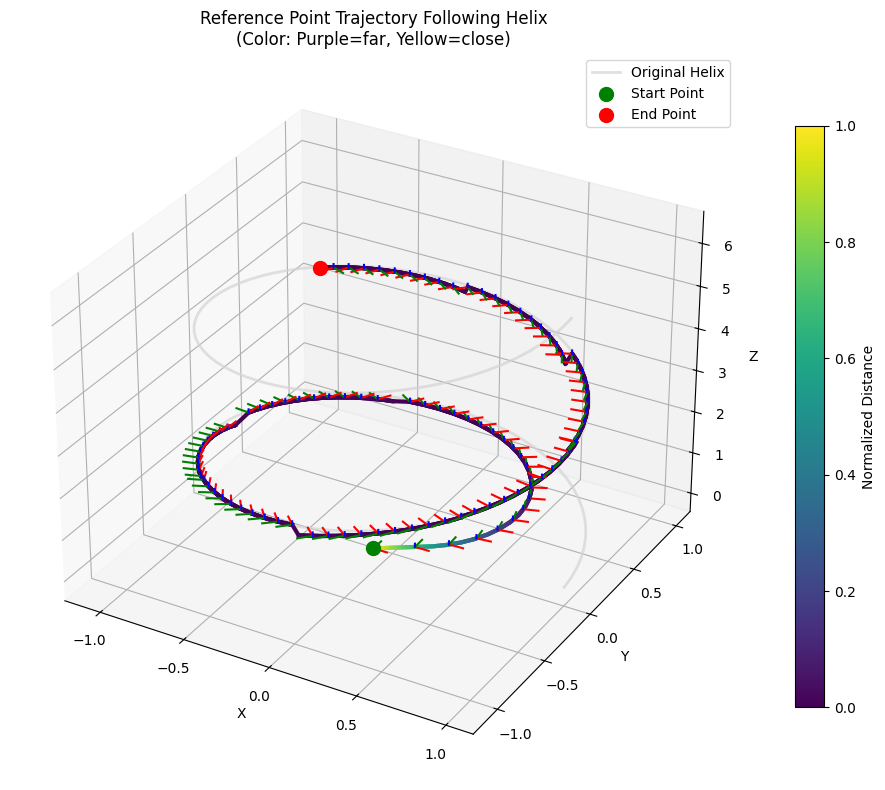

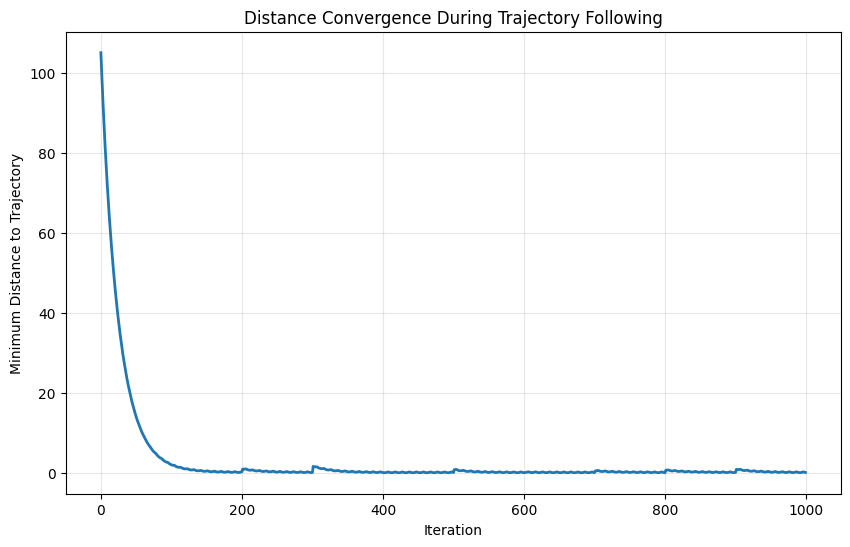

In [9]:
# ---------------------------------------
# 7. 참조점 궤적 시각화
# ---------------------------------------
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 원래 helix 궤적 (회색으로)
p_helix = Tseq[0, :, :3, 3].cpu().numpy()
ax.plot(p_helix[:, 0], p_helix[:, 1], p_helix[:, 2], 
        color='lightgray', linewidth=2, alpha=0.7, label='Original Helix')

# 참조점 궤적 추출
p_ref_traj = T_ref_trajectory[:, :3, 3].cpu().numpy()  # (100, 3)

# 거리에 따른 색상 매핑
distances_norm = np.array(distances)
distances_norm = (distances_norm - distances_norm.min()) / (distances_norm.max() - distances_norm.min())
cmap = plt.cm.get_cmap('viridis')

# 참조점 궤적을 색상으로 구분해서 그리기
for i in range(len(p_ref_traj)-1):
    ax.plot(p_ref_traj[i:i+2, 0], p_ref_traj[i:i+2, 1], p_ref_traj[i:i+2, 2],
            color=cmap(distances_norm[i]), linewidth=3)

# 참조점 궤적에 작은 프레임들 추가
scale = 0.08
for i in range(0, len(T_ref_trajectory), 10):  # 매 10번째마다
    R_i = T_ref_trajectory[i, :3, :3].cpu().numpy()
    p_i = T_ref_trajectory[i, :3, 3].cpu().numpy()
    
    # X-axis (red)
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,0]],
            [p_i[1], p_i[1] + scale*R_i[1,0]],
            [p_i[2], p_i[2] + scale*R_i[2,0]],
            color='r', linewidth=1.5)
    # Y-axis (green)  
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,1]],
            [p_i[1], p_i[1] + scale*R_i[1,1]],
            [p_i[2], p_i[2] + scale*R_i[2,1]], 
            color='g', linewidth=1.5)
    # Z-axis (blue)
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,2]],
            [p_i[1], p_i[1] + scale*R_i[1,2]],
            [p_i[2], p_i[2] + scale*R_i[2,2]],
            color='b', linewidth=1.5)

# 시작점과 끝점 표시
ax.scatter(*p_ref_traj[0], color='green', s=100, label='Start Point')
ax.scatter(*p_ref_traj[-1], color='red', s=100, label='End Point')

ax.set_xlabel('X')
ax.set_ylabel('Y') 
ax.set_zlabel('Z')
ax.set_title('Reference Point Trajectory Following Helix\n(Color: Purple=far, Yellow=close)')
ax.legend()

# 컬러바 추가
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=distances_norm.min(), vmax=distances_norm.max()))
sm.set_array([])
plt.colorbar(sm, ax=ax, shrink=0.8, label='Normalized Distance')

plt.tight_layout()
plt.show()

# ---------------------------------------
# 8. 거리 변화 그래프
# ---------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(distances, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Minimum Distance to Trajectory')
plt.title('Distance Convergence During Trajectory Following')
plt.grid(True, alpha=0.3)
plt.show()

Shapes: torch.Size([1, 400, 6]) torch.Size([1, 1, 6]) torch.Size([1, 400, 4, 4]) torch.Size([1, 1, 4, 4])


/tmp/ipykernel_3354309/3314196875.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


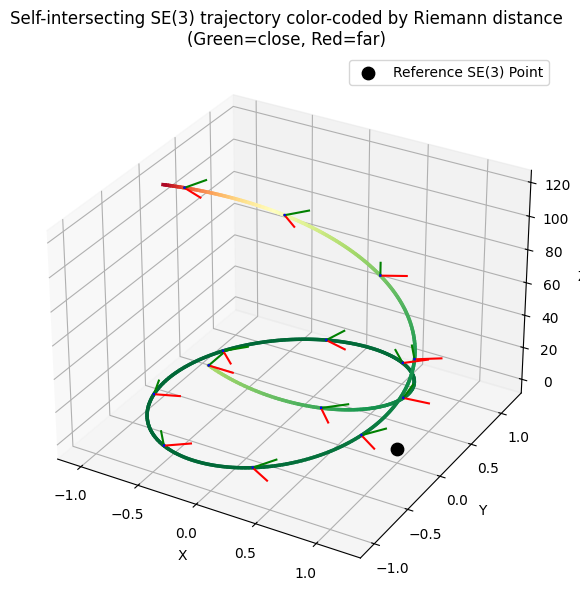

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils.distance import riemann_anisotropic_distance_SE3_PT
from utils.SE3_functions import *
from utils.Lie_old import *

# ---------------------------------------
# 1. Basic SE(3) utilities
# ---------------------------------------
def hat(v):
    """Convert vector (3,) to skew-symmetric matrix (3x3)"""
    w = torch.zeros(v.shape[:-1] + (3,3), device=v.device, dtype=v.dtype)
    w[...,0,1] = -v[...,2]; w[...,0,2] = v[...,1]
    w[...,1,0] = v[...,2];  w[...,1,2] = -v[...,0]
    w[...,2,0] = -v[...,1]; w[...,2,1] = v[...,0]
    return w

def make_SE3(R, p):
    """Compose SE(3) matrix from rotation R (BxTx3x3) and position p (BxTx3)"""
    B, Tn = R.shape[:2]
    T = torch.eye(4, device=R.device, dtype=R.dtype).repeat(B, Tn, 1, 1)
    T[...,:3,:3] = R
    T[...,:3,3] = p
    return T

def invSE3(T):
    """Inverse of SE(3) transformation"""
    R = T[...,:3,:3]
    p = T[...,:3,3]
    Tinv = torch.eye(4, device=T.device, dtype=T.dtype).expand_as(T).clone()
    Tinv[...,:3,:3] = R.transpose(-1,-2)
    Tinv[...,:3,3] = -torch.matmul(R.transpose(-1,-2), p.unsqueeze(-1))[...,0]
    return Tinv


# ---------------------------------------
# 2. Custom SE(3) trajectory (one intersection, then continues)
# ---------------------------------------
B, Tn = 1, 400
device = torch.device('cpu')
t = torch.linspace(-0.5*np.pi, 3*np.pi, Tn).to(device)

r = 1.0      # helix radius
a = 3.0      # amplitude controlling shape of z
k = 0.15     # linear upward drift

# Position
p = torch.stack([
    r * torch.cos(t),
    r * torch.sin(t),
    a * (t - np.pi)**2,  # makes one intersection near t ≈ π
], dim=-1).unsqueeze(0).to(device)

# Orientation: periodic, matching at intersection
theta = 0.8 * torch.sin(2 * t)  # rotation angle about z-axis
axis = torch.tensor([0., 0., 1.], device=device).expand(Tn, 3)
w = axis * theta.unsqueeze(-1)
R = expSO3(w).unsqueeze(0)

# NaN safety
nan_mask = torch.isnan(R).any(dim=(-2, -1))
if nan_mask.any():
    print(f"[Warning] {nan_mask.sum().item()} NaN rotations replaced with I")
    I = torch.eye(3, device=R.device, dtype=R.dtype).expand_as(R)
    R = torch.where(nan_mask[..., None, None], I, R)

# Compose SE(3)
Tseq = make_SE3(R, p)


# ---------------------------------------
# 3. Compute body velocity (Vb)
# ---------------------------------------
dT = Tseq[:,1:]
T  = Tseq[:,:-1]
T_rel = torch.matmul(invSE3(T.reshape(-1,4,4)), dT.reshape(-1,4,4)).reshape(Tn-1,4,4)
Vb = logSE3(T_rel)
Vb = torch.cat((Vb, torch.zeros_like(Vb[0]).unsqueeze(0)), dim=0)  # pad last
Vb = screw_bracket(Vb).unsqueeze(0)  # shape: (B, Tn, 6)


# ---------------------------------------
# 4. Reference SE(3) point
# ---------------------------------------
T_ref = make_SE3(
    torch.eye(3).unsqueeze(0).unsqueeze(0).to(device),
    torch.tensor([[[1.0, 0.0, 0.2]]], device=device)
)
Vb_ref = torch.zeros(B, 1, 6, device=device)


# ---------------------------------------
# 5. Compute SE(3) anisotropic distance
# ---------------------------------------
if torch.isnan(Vb).any():
    print("Vb contains NaN")
if torch.isnan(Tseq).any():
    print("Tseq contains NaN")

print("Shapes:", Vb.shape, Vb_ref.shape, Tseq.shape, T_ref.shape)

d, _, _ = riemann_anisotropic_distance_SE3_PT(
    Tseq, T_ref.repeat(1, Tn, 1, 1),
    Vb1=Vb, Vb2=Vb_ref.repeat(1, Tn, 1),
    lambda_rot=1.0, lambda_pos=100.0, lambda_vel=0.1,
    alpha_dir=10.0, beta_mag=1.0, sigma=0.5
)

dist = d[0].cpu().numpy()
dist_norm = (dist - dist.min()) / (dist.max() - dist.min())


# ---------------------------------------
# 6. Visualization: trajectory with distance color
# ---------------------------------------
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.cm.get_cmap('RdYlGn_r')

# Color-coded trajectory
for i in range(Tn-1):
    ax.plot(
        p[0, i:i+2, 0].cpu().numpy(),
        p[0, i:i+2, 1].cpu().numpy(),
        p[0, i:i+2, 2].cpu().numpy(),
        color=cmap(dist_norm[i]),
        linewidth=2.5,
    )

# Local frames
scale = 0.2
for i in range(0, Tn, 30):
    R_i = Tseq[0, i, :3, :3].cpu().numpy()
    p_i = Tseq[0, i, :3, 3].cpu().numpy()
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,0]],
            [p_i[1], p_i[1] + scale*R_i[1,0]],
            [p_i[2], p_i[2] + scale*R_i[2,0]], color='r')
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,1]],
            [p_i[1], p_i[1] + scale*R_i[1,1]],
            [p_i[2], p_i[2] + scale*R_i[2,1]], color='g')
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,2]],
            [p_i[1], p_i[1] + scale*R_i[1,2]],
            [p_i[2], p_i[2] + scale*R_i[2,2]], color='b')

# Reference point
p_ref = T_ref[0,0,:3,3].cpu().numpy()
ax.scatter(*p_ref, color='black', s=80, label='Reference SE(3) Point')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Self-intersecting SE(3) trajectory color-coded by Riemann distance\n(Green=close, Red=far)')
plt.legend()
plt.show()


In [11]:
from utils.SE3_functions import *

def gvf_SE3_distance(Tsample, eta_R, eta_p, Ttraj, Tdottraj, T_closest,index_closest, c=1, d=100, version='Tdot'):
    if len(Tsample.shape) == 2:
        Tsample = Tsample.unsqueeze(0)
    if len(Tsample.shape) == 4:
        Tsample = Tsample.squeeze(0)

    # pdot
    # print(Tdottraj.shape,Tsample.shape,T_closest.shape)
    # print(Tdottraj[:,index_closest,:])
    Tdottraj_closest = Vb_to_Tdot(Tdottraj[:,index_closest,:],Ttraj[:,index_closest,:])
    # print("\n",Tdottraj_closest,"\n")
    # print(Tdottraj_closest.shape,"----------------------")
    pdot_parallel = Tdottraj_closest[:,0:3,3].to(Tsample)
    # print(T_closest[:,0:3,3].shape,Tsample[:,0:3,3].squeeze(0).shape)
    pdot_contract = T_closest[:,0:3,3].to(Tsample) - Tsample[:,0:3,3].to(Tsample)
    
    # Rdot
    # print(pdot_parallel,pdot_contract)
    Rdot_closest = Tdottraj_closest[:,0:3,0:3]
    # print(Ttraj.shape,Tsample.shape,Rdot_closest.shape)
    Rdot_parallel = parallel_transport_SO3(Ttraj[:,index_closest,0:3,0:3], Tsample[:,0:3,0:3], Rdot_closest)
    Rdot_contract = vel_geo_0_SO3(Tsample[:,0:3,0:3], Ttraj[:,index_closest,0:3,0:3])
    
    if eta_R == torch.inf or eta_p == torch.inf:
        Tdot = torch.zeros_like(Tsample).to(Tsample)
        Tdot[:,:3,:3] = Rdot_contract
        Tdot[:,:3,3] = pdot_contract
    else:
        Tdot = torch.zeros_like(Tsample).to(Tsample)
        Tdot[:,:3,:3] = Rdot_parallel + eta_R*Rdot_contract
        Tdot[:,:3,3] = pdot_parallel + eta_p*pdot_contract
    if version == 'qdot':
        output = Tdot_to_qdot(Tdot, Tsample)
    elif version == 'wbpdot':
        output = Tdot_to_wbpdot(Tdot, Tsample)
    else:
        output = Tdot
    
    return output

In [12]:
T_ref = make_SE3(
    torch.tensor([[[0.0, -1.0, 0.0],
                   [-1.0, 0.0, 0.0],
                   [0.0, 0.0, 1.0]]], device=device).unsqueeze(0),
    torch.tensor([[[0.0, -0.6, 50]]], device=device)
)
Vb_ref = torch.zeros(B, 1, 6, device=device)

dt=0.05



# 궤적 저장을 위한 리스트
T_ref_trajectory = []
distances = []

for i in range(10000):
    # 현재 T_ref 저장
    T_ref_trajectory.append(T_ref.clone())
    
    d, _, _ = riemann_anisotropic_distance_SE3_PT(
        Tseq, T_ref.repeat(1, Tn, 1, 1),
        Vb1=Vb, Vb2=Vb_ref.repeat(1, Tn, 1),
        lambda_rot=1.0, lambda_pos=100.0, lambda_vel=0.0,
        alpha_dir=10.0, beta_mag=1.0, sigma=0.5
    )

    # 최소 거리도 저장
    distances.append(torch.min(d).item())

    index_closest = torch.argmin(d, dim=1)
    T_closest = Tseq[:, index_closest, :, :].squeeze(0)

    Tdot = gvf_SE3_distance(
        Tsample=T_ref,
        eta_R=0.02,
        eta_p=0.02,
        Ttraj=Tseq,
        Tdottraj=Vb,
        T_closest=T_closest,
        index_closest=index_closest.item(),
        c=1,
        d=100,
        version='Tdot'
    )
    
    T_cur = T_ref.clone()[0, 0]
    wb = T_cur[0:3, 0:3].T @ Tdot[0, :3, :3] * dt
    Rb = exp_so3(wb.unsqueeze(0)).squeeze()
    R = T_cur[0:3, 0:3] @ Rb
    
    p = Tdot[0, :3, 3] * dt + T_cur[:3, 3]

    # -------------------------------
    # Noise injection after 200 steps
    # -------------------------------
    if i >= 200 and (i % 500 == 0):
        noise = 0.01 * torch.randn_like(p)  # e.g. Gaussian noise with std=0.01
        p = p + noise
        if i % 1000 == 0:
            R = T_cur[0:3, 0:3] @ exp_so3((0.1 * torch.randn(3, device=device)).unsqueeze(0)).squeeze()
        # print(f"[Step {i}] Added position noise: {noise.cpu().numpy()}")
    # -------------------------------

    # Update SE3
    T_ref[0, 0, 0:3, :3] = R
    T_ref[0, 0, 0:3, 3] = p

    # Update Vb_ref
    Vb_mat = Tdot_to_Vb(Tdot, T_ref.squeeze(0))
    Vb_ref = skew_se3(Vb_mat).unsqueeze(0)



# 궤적을 tensor로 변환
T_ref_trajectory = torch.stack(T_ref_trajectory).squeeze()  # (100, 4, 4)
print(f"T_ref trajectory shape: {T_ref_trajectory.shape}")
print(f"Final distance to trajectory: {distances[-1]:.6f}")

T_ref trajectory shape: torch.Size([10000, 4, 4])
Final distance to trajectory: 0.057309


/tmp/ipykernel_3354309/1666875815.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


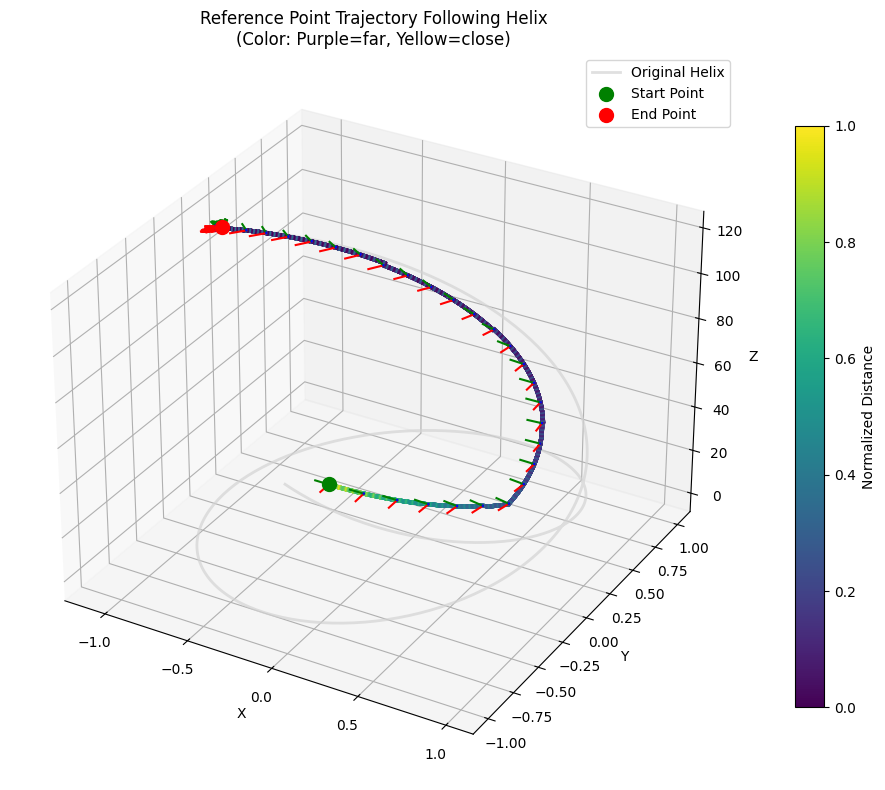

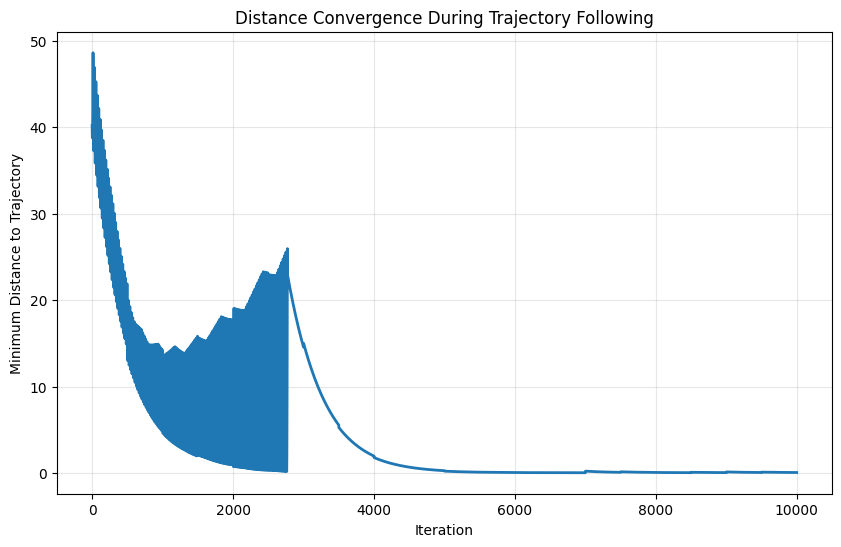

In [13]:
# ---------------------------------------
# 7. 참조점 궤적 시각화
# ---------------------------------------
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 원래 helix 궤적 (회색으로)
p_helix = Tseq[0, :, :3, 3].cpu().numpy()
ax.plot(p_helix[:, 0], p_helix[:, 1], p_helix[:, 2], 
        color='lightgray', linewidth=2, alpha=0.7, label='Original Helix')

# 참조점 궤적 추출
p_ref_traj = T_ref_trajectory[:, :3, 3].cpu().numpy()  # (100, 3)

# 거리에 따른 색상 매핑
distances_norm = np.array(distances)
distances_norm = (distances_norm - distances_norm.min()) / (distances_norm.max() - distances_norm.min())
cmap = plt.cm.get_cmap('viridis')

# 참조점 궤적을 색상으로 구분해서 그리기
for i in range(len(p_ref_traj)-1):
    ax.plot(p_ref_traj[i:i+2, 0], p_ref_traj[i:i+2, 1], p_ref_traj[i:i+2, 2],
            color=cmap(distances_norm[i]), linewidth=3)

# 참조점 궤적에 작은 프레임들 추가
scale = 0.08
for i in range(0, len(T_ref_trajectory), 100):  # 매 10번째마다
    R_i = T_ref_trajectory[i, :3, :3].cpu().numpy()
    p_i = T_ref_trajectory[i, :3, 3].cpu().numpy()
    
    # X-axis (red)
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,0]],
            [p_i[1], p_i[1] + scale*R_i[1,0]],
            [p_i[2], p_i[2] + scale*R_i[2,0]],
            color='r', linewidth=1.5)
    # Y-axis (green)  
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,1]],
            [p_i[1], p_i[1] + scale*R_i[1,1]],
            [p_i[2], p_i[2] + scale*R_i[2,1]], 
            color='g', linewidth=1.5)
    # Z-axis (blue)
    ax.plot([p_i[0], p_i[0] + scale*R_i[0,2]],
            [p_i[1], p_i[1] + scale*R_i[1,2]],
            [p_i[2], p_i[2] + scale*R_i[2,2]],
            color='b', linewidth=1.5)

# 시작점과 끝점 표시
ax.scatter(*p_ref_traj[0], color='green', s=100, label='Start Point')
ax.scatter(*p_ref_traj[-1], color='red', s=100, label='End Point')

ax.set_xlabel('X')
ax.set_ylabel('Y') 
ax.set_zlabel('Z')
ax.set_title('Reference Point Trajectory Following Helix\n(Color: Purple=far, Yellow=close)')
ax.legend()

# 컬러바 추가
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=distances_norm.min(), vmax=distances_norm.max()))
sm.set_array([])
plt.colorbar(sm, ax=ax, shrink=0.8, label='Normalized Distance')

plt.tight_layout()
plt.show()

# ---------------------------------------
# 8. 거리 변화 그래프
# ---------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(distances, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Minimum Distance to Trajectory')
plt.title('Distance Convergence During Trajectory Following')
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
torch.tensor([[[0.0, -1.0, 0.0],
                   [-1.0, 0.0, 0.0],
                   [0.0, 0.0, 1.0]]]).shape
torch.eye(3).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 3, 3])